Test the function for training guassian process regression

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster
import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
x = np.linspace(-5,5,200)

In [3]:
y = np.exp(-1 * np.square(x)/np.abs(x))

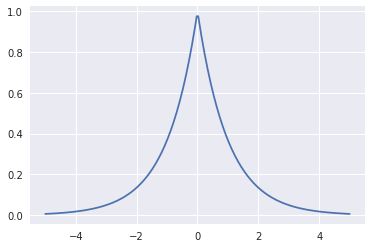

In [4]:
plt.plot(x, y)

In [5]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


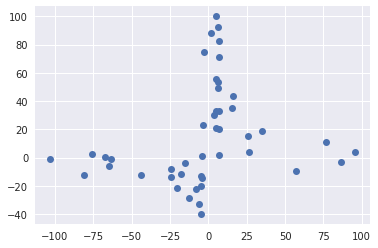

In [227]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]
plt.plot(data1['dt1'], data1['dw_mean'],'o', label='Raw_data_train')

In [398]:
x = data1['dt1'].reshape(-1,1)
y = data1['dw_mean'].reshape(-1,1)

In [399]:
x_test = np.linspace(-100,100,200).reshape(-1,1)

In [400]:
from modelval import GP_regressor

In [401]:
# f, v_f, lp = GP_regressor.gp_regessor(x, y, x_test, sigma_obs=1.6, sigma_kernel=1.5)
# std = np.sqrt(v_f.diagonal()).reshape(-1,1)

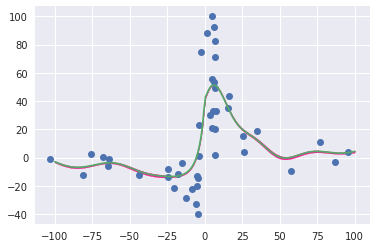

In [402]:
f, v_f, lp = GP_regressor.gp_regessor(x, y, x_test,sigma_kernel=1.5, bias=5, sigma_obs=1, noise_const=100, if_stat_kernel=False, if_stat_noise=False)
std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)
plt.plot(data1['dt1'], data1['dw_mean'],'o', label='Raw_data_train')
plt.plot(x_test, f)
plt.fill_between(np.squeeze(x_test), np.squeeze(f-1.96*std), np.squeeze(f+1.96*std), alpha=1, color='deeppink')

In [ ]:
# Hyperparameter search

# Create the parameter list
param_list={
    'noise_const': np.linspace(100,1000,10),    # Dependence of noise on |x|
    'sigma_obs': np.linspace(1,3,20),            # Noise variance
    'bias': np.linspace(1,5,5),                 # Mimimum length scale
    'sigma_kernel': np.linspace(1,3,20),        # length scale for covariance matrix
}

# Convert to parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = list(ParameterGrid(param_list))

# Seperate the data into training and validation
from sklearn.model_selection import KFold

x = data1['dt1'].reshape(-1,1)
y = data1['dw_mean'].reshape(-1,1)

kf = KFold(n_splits=5, shuffle=True)
# Perform k-fold cross validation and get mean mse
mse = np.zeros(len(param_grid))
for i in range(len(param_grid)):
    for train_index, test_index in kf.split(x):
        mse_tmp = np.zeros(kf.get_n_splits(x))
        x_train = x[train_index,:].reshape(-1,1)
        y_train = y[train_index,:].reshape(-1,1)
        x_test = x[test_index,:].reshape(-1,1)
        y_test = y[test_index,:].reshape(-1,1)
        f, _, _ = GP_regressor.gp_regessor(x_train, y_train, x_test, if_stat_kernel=False, if_stat_noise=False, **param_grid[i])
        mse_tmp = np.mean(np.square(f-y_test))
    mse[i] = np.mean(mse_tmp)
    
# Choose the parameter with minimum mse
param_grid[np.where(mse == np.min(mse))[0][0]]

In [377]:
kfold.get_n_splits?

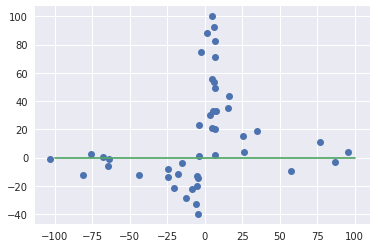

In [177]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = RBF(1.2)
gp_rg = GaussianProcessRegressor(kernel = kernel)
gp_rg.fit(x,y)
f = gp_rg.predict(x_test)
plt.plot(data1['dt1'], data1['dw_mean'],'o', label='Raw_data_train')
plt.plot(x_test, f)

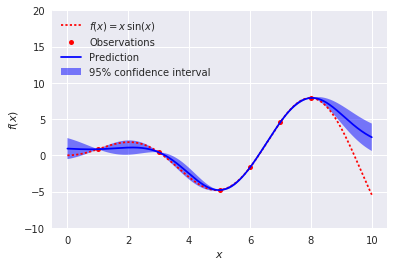

In [220]:
# Test with toy example
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).reshape(-1,1)

# Observations
y = f(X).ravel().reshape(-1,1)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Fit to data using Maximum Likelihood Estimation of the parameters
y_pred, v_f, lp = GP_regressor.gp_regessor(X, y, x, sigma_obs=0, sigma_kernel=0.1)
sigma = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

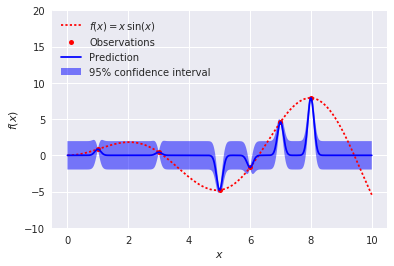

In [221]:
np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
kernel = RBF(0.1)
gp = GaussianProcessRegressor(kernel=kernel)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
